# Import Library

In [3]:
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import string
import tensorflow as tf

In [5]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Open the data file

In [4]:
with open('/content/waste_management3.json') as content:
  data = json.load(content)

# Create a list of the data

In [6]:
# Mendapatkan semua data ke dalam list
tags = [] # Data tag
inputs = [] # Data input atau pattern
responses = {} # Data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # Add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Split the data into training and testing data

In [8]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(inputs, tags,test_size=0.2, random_state=42)

# Konversi data ke dalam dataframe
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

# Lowercase and remove punctuation

In [13]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

# Lemmatize the words

In [14]:
# Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk melakukan lemmatization pada kata-kata dalam kalimat
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi kata-kata dalam kalimat
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    lemmatized_text = ' '.join(lemmatized_tokens)  # Menggabungkan kembali kata-kata menjadi kalimat
    return lemmatized_text

# Contoh penggunaan fungsi lemmatize_text pada dataset
train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

# Create a bag of words

In [15]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

x_train = tokenizer.texts_to_sequences(train_data['patterns'])
x_test = tokenizer.texts_to_sequences(test_data['patterns'])

# Apply padding to the bag of words

In [16]:
# Apply padding
max_sequence_length = max(len(seq) for seq in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

# Label encode the target

In [17]:
# Combine tags from train_data and test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

# Encoding the outputs
le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

# Split the data into training and testing data

In [18]:
# Splitting the dataset
train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)

# Create the model

In [19]:
# Menambahkan regularisasi L2
regularization = regularizers.l2(0.01)

# Mengubah tingkat dropout menjadi 0.5
dropout_rate = 0.5

# Mendefinisikan input layer
i = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(i)

# Bidirectional LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

# Bidirectional GRU layer
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

# Flatten layer
x = Flatten()(x)

# Dense layer with L2 regularization
dense_units = 50
x = Dense(dense_units, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(dropout_rate)(x)

# Output layer
num_classes = len(classes)
x = Dense(num_classes, activation="softmax")(x)
model = Model(i, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 100)           17500     
                                                                 
 bidirectional (Bidirection  (None, 16, 64)            34048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 16, 128)           49920     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 50)                102450

# Callbacks

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.8:
            print("\nReached 0.7 val acc so cancelling training!")

            # Stop training once the above condition is met
            self.model.stop_training = True

# Initialize the optimizer

In [21]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Instantiate the callback class
cb = myCallback()

# Compile the model

In [22]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# Train the model

In [23]:
%%time
# Training the model
batch_size=32
history = model.fit(train_dataset[0], train_dataset[1], epochs=500, callbacks = [cb], validation_data=test_dataset)

Epoch 1/500
7/7 [==============================] - 17s 347ms/step - loss: 4.6222 - accuracy: 0.0269 - val_loss: 4.4619 - val_accuracy: 0.0179
Epoch 2/500
7/7 [==============================] - 1s 122ms/step - loss: 4.3436 - accuracy: 0.0314 - val_loss: 4.2489 - val_accuracy: 0.0179
Epoch 3/500
7/7 [==============================] - 1s 90ms/step - loss: 4.1342 - accuracy: 0.0359 - val_loss: 4.0906 - val_accuracy: 0.0179
Epoch 4/500
7/7 [==============================] - 1s 86ms/step - loss: 4.0119 - accuracy: 0.0538 - val_loss: 3.9618 - val_accuracy: 0.0179
Epoch 5/500
7/7 [==============================] - 0s 18ms/step - loss: 3.8703 - accuracy: 0.0493 - val_loss: 3.8453 - val_accuracy: 0.0179
Epoch 6/500
7/7 [==============================] - 1s 59ms/step - loss: 3.7413 - accuracy: 0.0852 - val_loss: 3.7039 - val_accuracy: 0.0357
Epoch 7/500
7/7 [==============================] - 0s 56ms/step - loss: 3.6271 - accuracy: 0.0673 - val_loss: 3.6089 - val_accuracy: 0.0357
Epoch 8/500
7/7 [

# Show the accuracy and loss graph

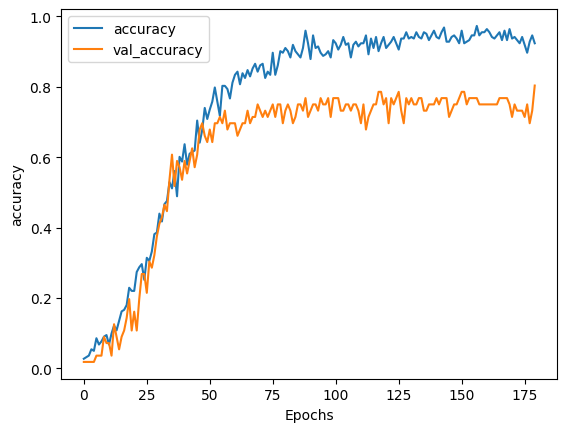

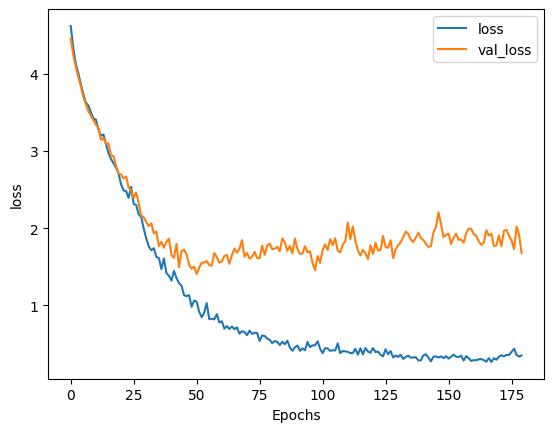

In [27]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test the model

In [25]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],max_sequence_length)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("🤖 ChatbotX :",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : apa itu sampah organik?
1/1 [==============================] - 1s 1s/step
🤖 ChatbotX : Pengertian dari limbah sampah organik adalah suatu limbah yang berasal dari sisa-sisa makanan atau tumbuhan yang dapat terurai dengan cepat.
👨‍🦰 Kamu : goodbye
1/1 [==============================] - 0s 20ms/step
🤖 ChatbotX : Bye!


# Save the model, and variables

In [28]:
# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Save the max_sequence_length
with open('max_sequence_length.pkl', 'wb') as file:
    pickle.dump(max_sequence_length, file)

# Save the le
with open('le.pkl', 'wb') as file:
    pickle.dump(le, file)

# Save the responses
with open('responses.pkl', 'wb') as file:
    pickle.dump(responses, file)

# Load the model, and variables

In [36]:
from keras.models import load_model

# Define your model and variables here
chatbot_model = load_model('/content/model.h5')
tokenizer = pickle.load(open('/content/tokenizer.pkl','rb'))
max_sequence_length = pickle.load(open('/content/max_sequence_length.pkl','rb'))
le = pickle.load(open('/content/le.pkl','rb'))
responses = pickle.load(open('/content/responses.pkl','rb'))

# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],max_sequence_length)

  # Mendapatkan hasil keluaran pada model
  output = chatbot_model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("🤖 ChatbotX :",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : apa itu sampah?
1/1 [==============================] - 3s 3s/step
🤖 ChatbotX : Limbah sampah adalah sisa dari suatu usaha atau kegiatan yang dihasilkan oleh manusia dalam upaya memenuhi kebutuhan sehari-hari 
👨‍🦰 Kamu : goodbye
1/1 [==============================] - 0s 20ms/step
🤖 ChatbotX : Bye!
